Code References: https://pythondata.com/forecasting-time-series-autoregression/
https://towardsdatascience.com/a-complete-guide-to-time-series-data-visualization-in-python-da0ddd2cfb01

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
import tools
%matplotlib inline

import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [37]:
plt.rcParams['figure.figsize']=(20,15)
plt.style.use('ggplot')

In [38]:
time_data = pd.read_csv("C:/Users/nichole/GMU_DAEN_690_FAA/laser_dates.csv",parse_dates=True)

In [39]:
time_data['date_only'] = pd.to_datetime(time_data['date_only'], format='%m/%d/%Y')

df1 = time_data['date_only'].dt.date.value_counts().sort_index().reset_index()
df1.columns = ['date_only','Count']
y = df1.set_index('date_only', inplace=True)

In [40]:
df1

,Count
date_only,
2011-01-01,17
2011-01-02,1
2011-01-03,6
2011-01-04,8
2011-01-05,3
...,...
2021-01-25,9
2021-01-26,11
2021-01-27,16


In [41]:
df1.to_csv(r'C:\Users\nichole\GMU_DAEN_690_FAA\LaserDates.csv')

<AxesSubplot:xlabel='date_only'>

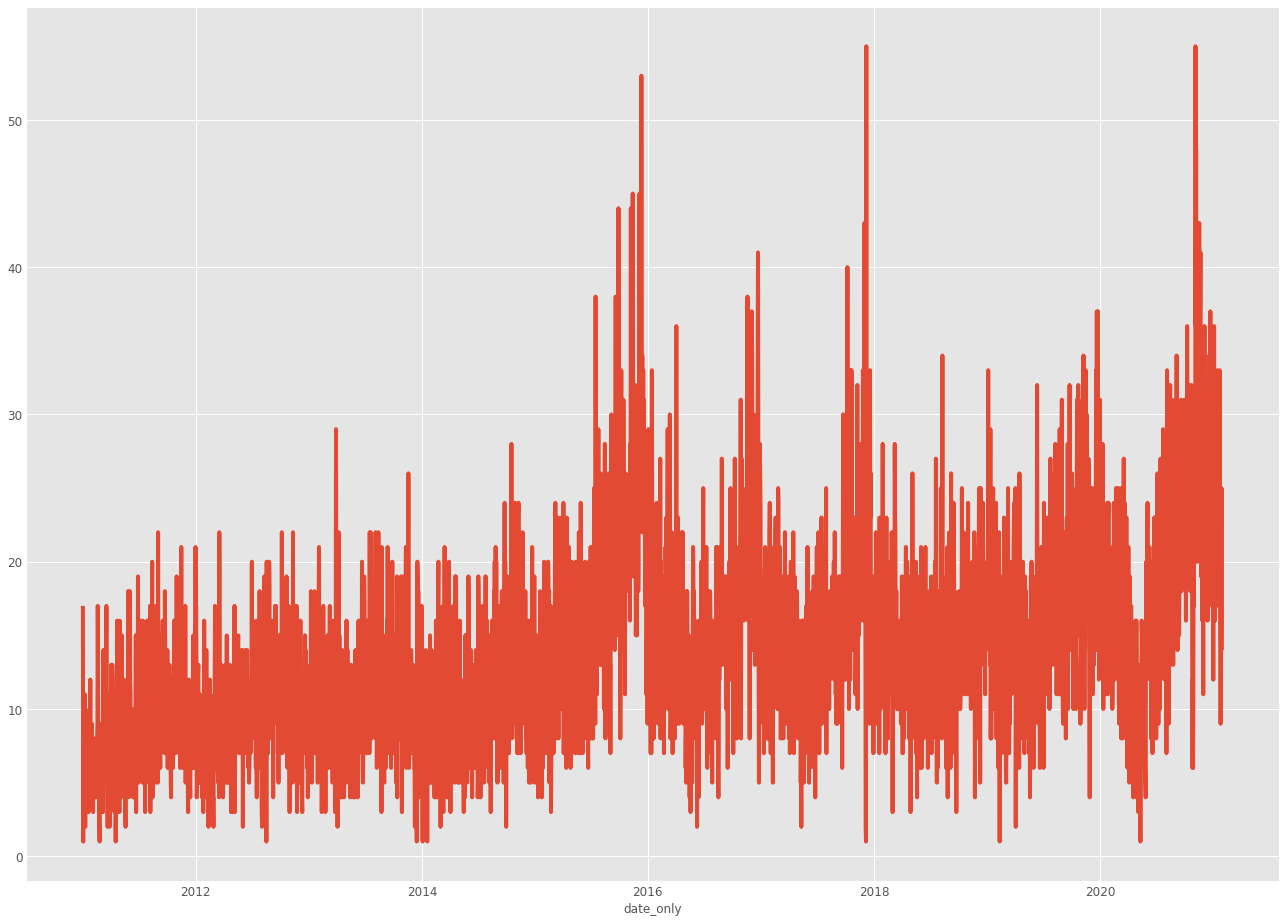

In [42]:
df1['Count'].plot()

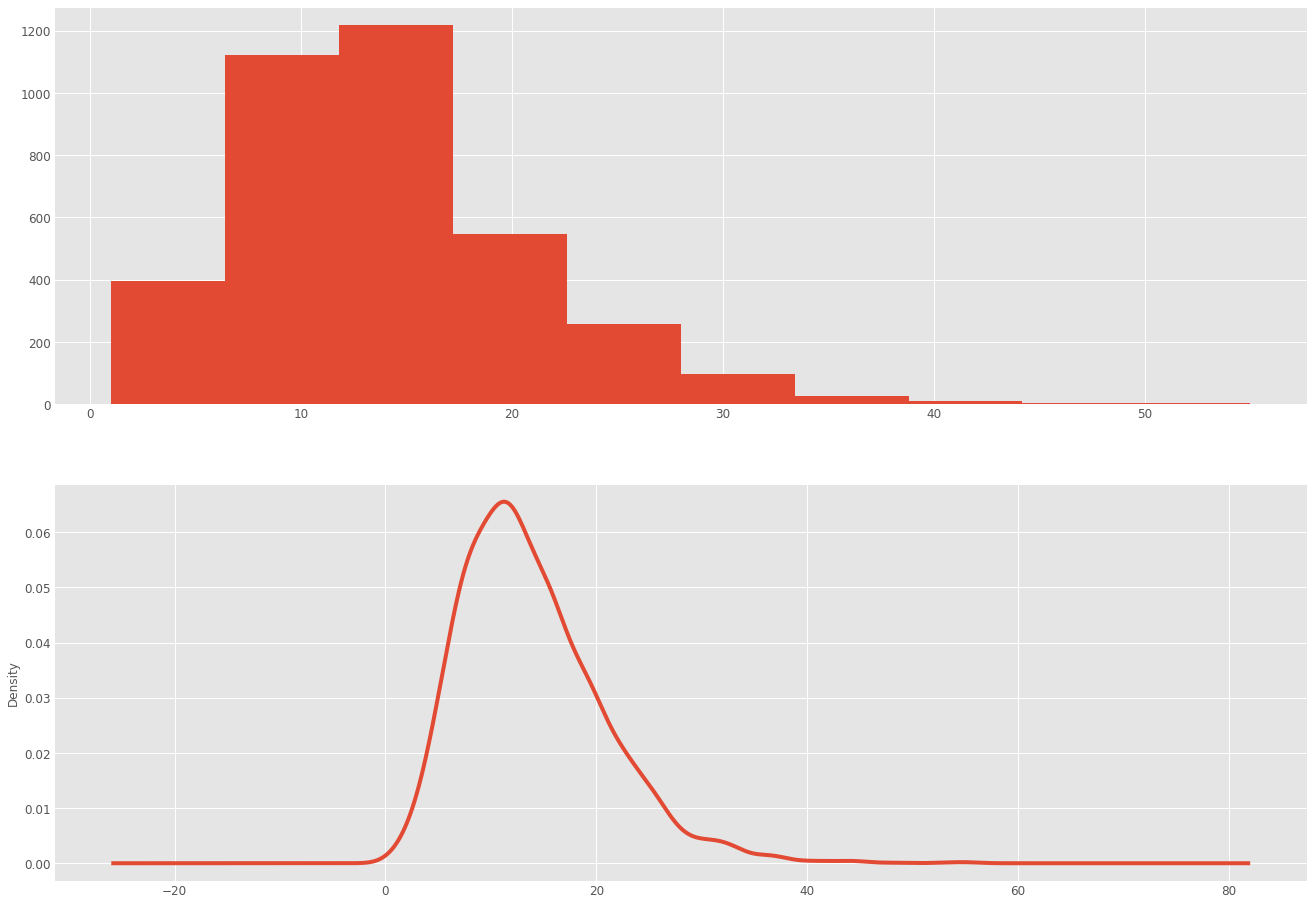

In [43]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
df1.Count.hist()
pyplot.subplot(212)
df1.Count.plot(kind='kde')
pyplot.show()

In [343]:
df1.index

Index([2011-01-01, 2011-01-02, 2011-01-03, 2011-01-04, 2011-01-05, 2011-01-06, 2011-01-07, 2011-01-08, 2011-01-09, 2011-01-10,
       ...
       2016-12-22, 2016-12-23, 2016-12-24, 2016-12-25, 2016-12-26, 2016-12-27, 2016-12-28, 2016-12-29, 2016-12-30, 2016-12-31], dtype='object', name='date_only', length=2191)

<AxesSubplot:xlabel='date_only', ylabel='Count'>

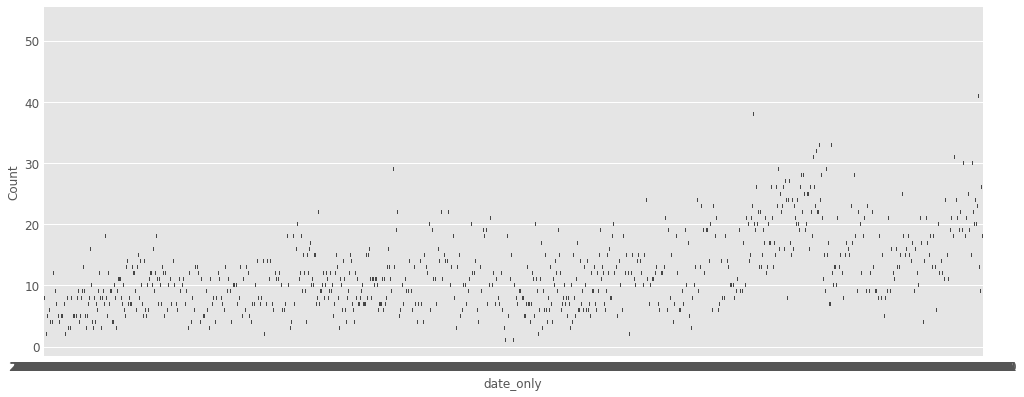

In [242]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df1.Count.index, df1.Count, ax=ax)

Let’s check for dependance (aka, correlation) – which is the first assumption for autoregression models. A visual method for checking correlation is to use pandas lag_plot() function to see how well the values of the original data are correlated with each other. If they are highly correlated, we’ll see a fairly close grouping of datapoints that align along some point/line on the plot.

In [9]:
import pandas.plotting

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

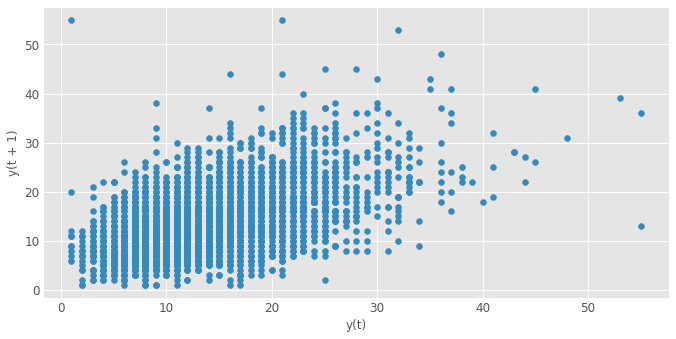

In [10]:
plt.rcParams['figure.figsize']=(10,5)
pd.plotting.lag_plot(df1['Count'])

#The shift function shifts the data before or after the specified amount of time. If I do not specify the time it will shift the data by one day by default. That means you will get the previous day's data. In financial data like this one, it is helpful to see previous day data and today's data side by side.

<AxesSubplot:xlabel='date_only'>

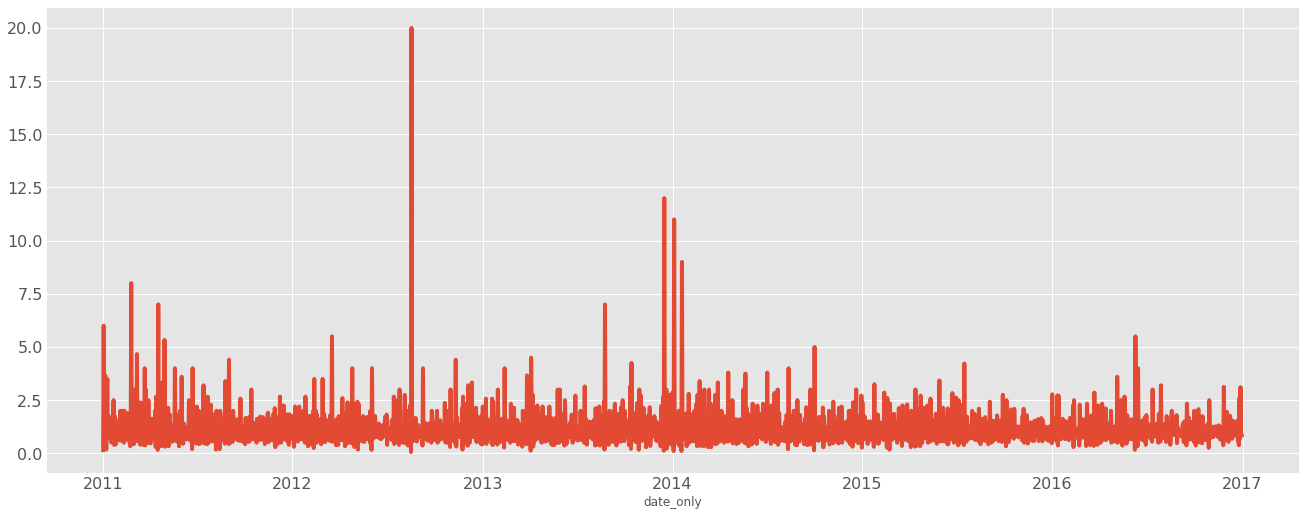

In [346]:
df1['Change'] = df1.Count.div(df1.Count.shift())
df1['Change'].plot(figsize=(20, 8), fontsize = 16)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

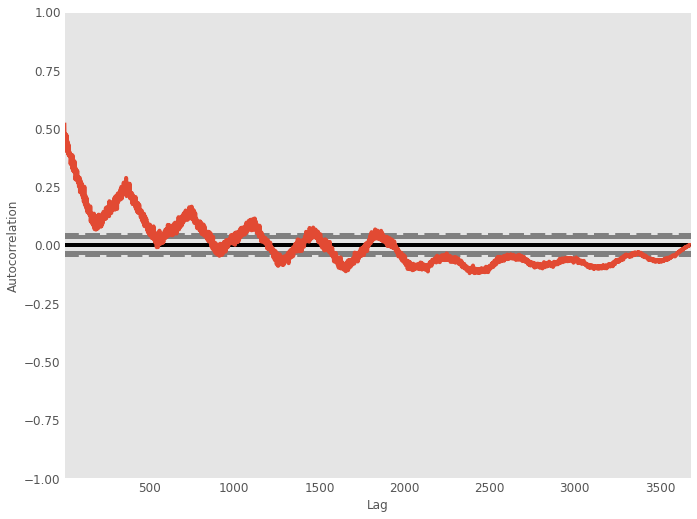

In [11]:
plt.rcParams['figure.figsize']=(10,8)
pd.plotting.autocorrelation_plot(df1['Count'])

In [12]:
df1['Count'].corr(df1['Count'].shift(100))

0.2472926509072742

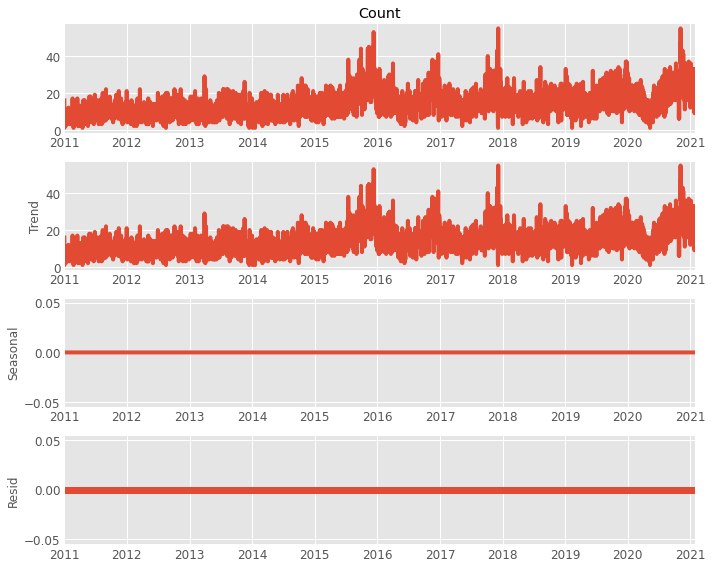

In [13]:
decomposed = seasonal_decompose(df1['Count'], model='additive', period=1)
x = decomposed.plot() #See note below about this

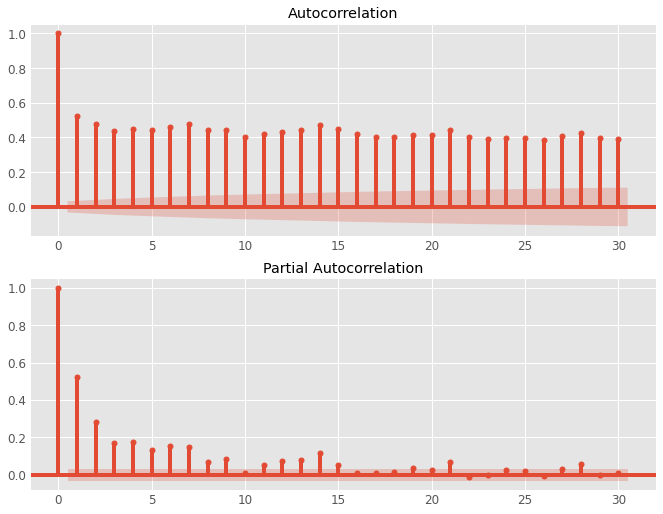

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(df1.Count, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df1.Count, ax=pyplot.gca(), lags = 30)
pyplot.show()

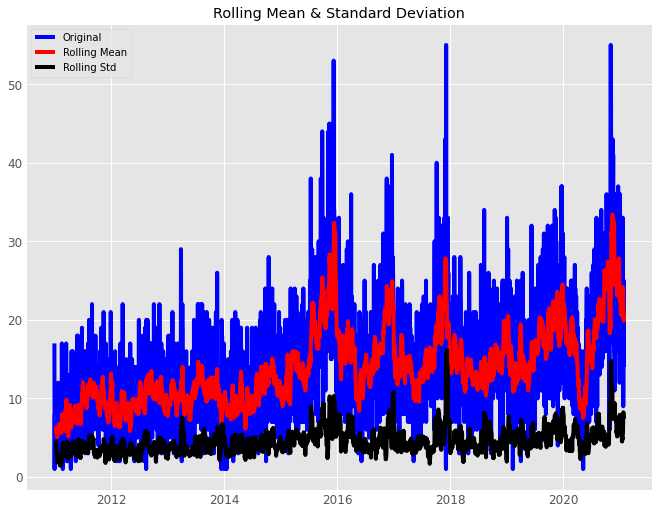

In [15]:
#Determing rolling statistics
rolmean = df1.rolling(window=12).mean()
rolstd = df1.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df1, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df1.Count, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.556562
p-value                           0.006648
#Lags Used                       27.000000
Number of Observations Used    3653.000000
Critical Value (1%)              -3.432141
Critical Value (5%)              -2.862332
Critical Value (10%)             -2.567191
dtype: float64


In [18]:
# fit AR model
model = AR(df1.Count)
res = model.fit(method='mle', maxlag=20, disp=1, maxiter=1000)

In [21]:
predicted = res.predict()

In [22]:
df1.count()

Count    3681
dtype: int64

In [23]:
predicted.count()

3681

<AxesSubplot:xlabel='date_only'>

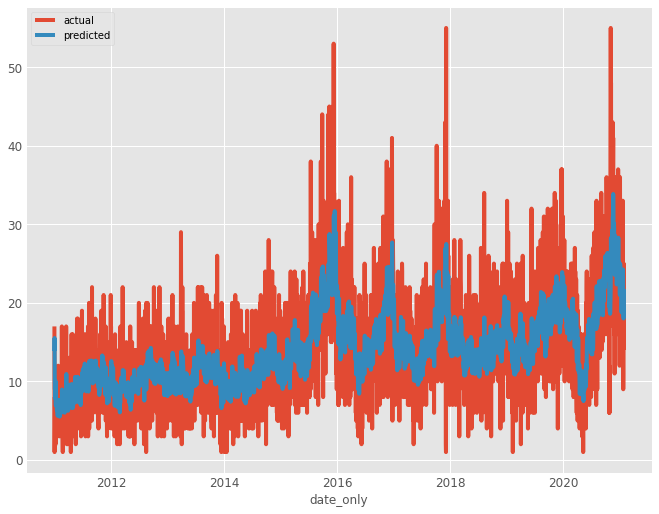

In [24]:
# Compare actuals vs AR predictions
compare_df = pd.concat(
    [df1['Count'],
    predicted], axis=1).rename(
    columns={'Count': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

In [25]:
#MSE of AR Model
y_forecasted = predicted
y_truth = df1.Count
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 25.97


In [26]:
#Root MSE of AR Model
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 5.1


In [27]:
#R-squared val of AR Model
r2_score(y_truth, y_forecasted)

0.43549268879717684

In [44]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

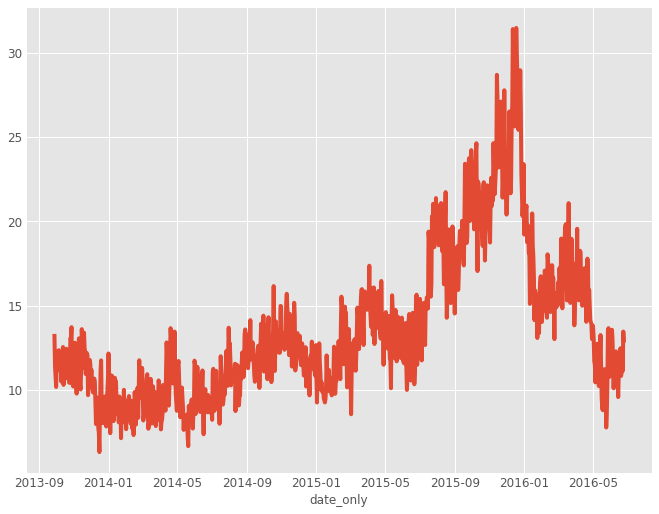

In [400]:
fig = res.predict(1000,2000).plot()

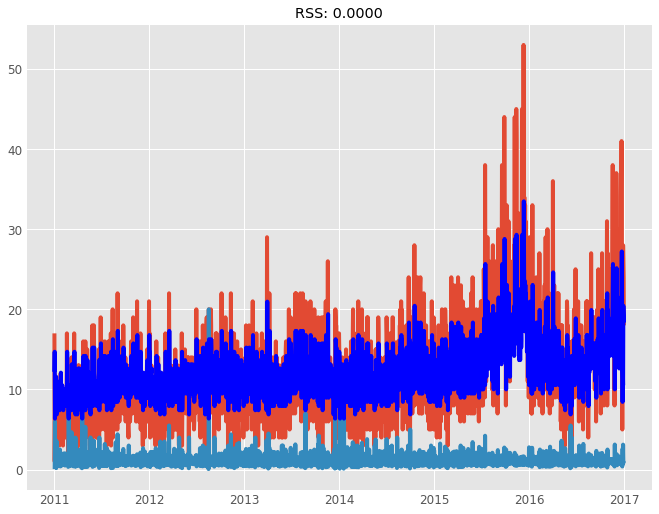

In [359]:
#Model fitted values
plt.plot(df1)
plt.plot(model_fit.fittedvalues, color='blue')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-df1)**2))
plt.show()

In [360]:
#Fitting the SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df1.Count,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1715      0.020      8.702      0.000       0.133       0.210
ma.L1         -1.0000      0.930     -1.075      0.282      -2.823       0.823
ar.S.L12      -0.4751      0.016    -29.046      0.000      -0.507      -0.443
sigma2        33.2039     31.003      1.071      0.284     -27.560      93.968


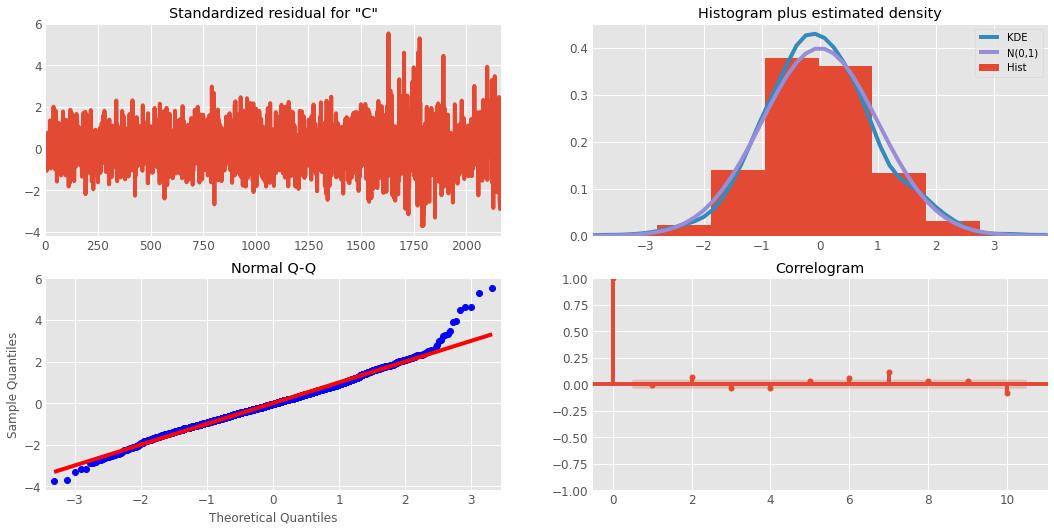

In [361]:
#SARIMAX plot diagnostics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [52]:
startdate = pd.to_datetime("2015-01-01").date()

In [363]:
begdate = pd.to_datetime("2011-01-01").date()

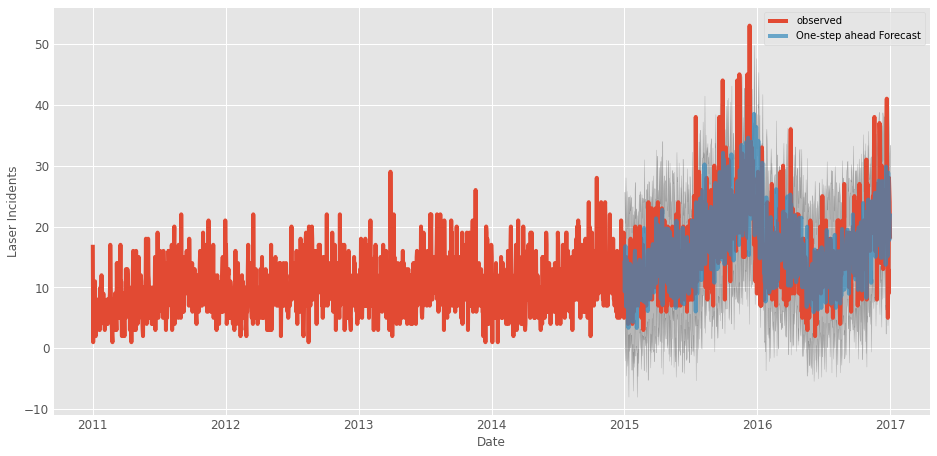

In [364]:
#Plotting SARIMAX predicted values vs originals
pred = results.get_prediction(start=startdate, dynamic=False)
pred_ci = pred.conf_int()
ax = df1.Count[begdate:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Laser Incidents')
plt.legend()
plt.show()

In [365]:
#SARIMAX MSE
y_forecasted = pred.predicted_mean
y_truth = df1.Count[startdate:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 49.85


In [366]:
#SARIMAX Root MSE
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 7.06


In [367]:
#SARIMAX R-squared
r2_score(y_truth, y_forecasted)

-0.010051928995215231

In [46]:
#Fitting the ARIMA model
model = ARIMA(df1.Count, order=(20,1,0))
model_fit = model.fit()

In [47]:
#ARIMA Model Summary
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Count   No. Observations:                 3680
Model:                ARIMA(20, 1, 0)   Log Likelihood              -11212.963
Method:                       css-mle   S.D. of innovations              5.093
Date:                Mon, 05 Apr 2021   AIC                          22469.927
Time:                        06:59:41   BIC                          22606.561
Sample:                             1   HQIC                         22518.566
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0034      0.010      0.331      0.741      -0.017       0.023
ar.L1.D.Count     -0.8085      0.016    -49.124      0.000      -0.841      -0.776
ar.L2.D.Count     -0.7122      0.021

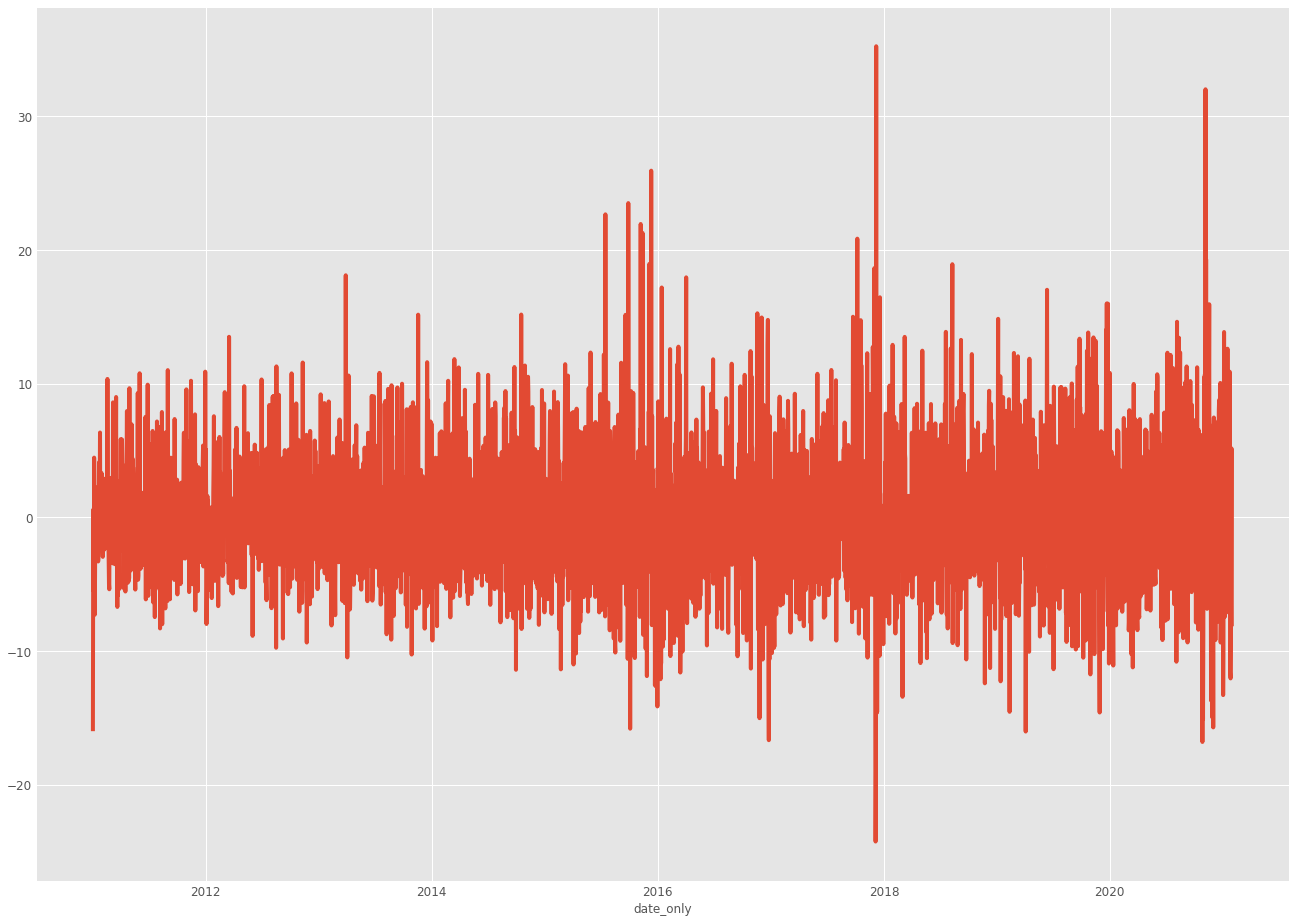

In [48]:
#ARIMA Model residuals
residuals = model_fit.resid
residuals.plot()
pyplot.show()

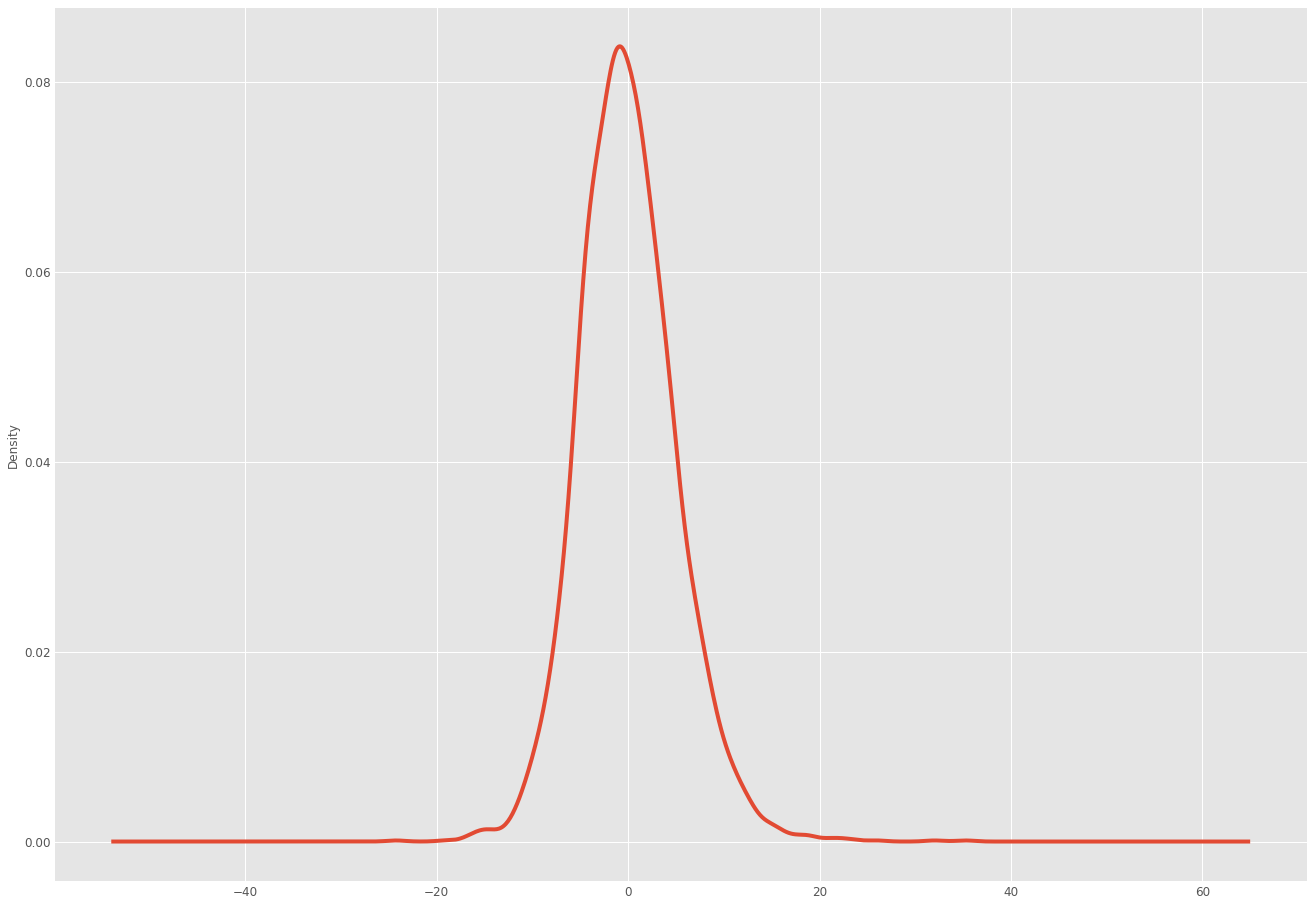

In [49]:
residuals.plot(kind='kde')
pyplot.show()

In [63]:
startdate2 = pd.to_datetime("2019-01-01").date()

predicted=13.856907, expected=22.000000
predicted=16.883854, expected=16.000000
predicted=16.989874, expected=16.000000
predicted=16.394865, expected=11.000000
predicted=13.688835, expected=12.000000
predicted=13.934974, expected=9.000000
predicted=13.985771, expected=12.000000
predicted=12.734107, expected=15.000000
predicted=13.321282, expected=16.000000
predicted=13.278867, expected=9.000000
predicted=11.673088, expected=12.000000
predicted=11.443865, expected=13.000000
predicted=12.842579, expected=19.000000
predicted=15.178219, expected=18.000000
predicted=15.557733, expected=18.000000
predicted=14.963016, expected=16.000000
predicted=15.581263, expected=14.000000
predicted=15.573756, expected=19.000000
predicted=17.609864, expected=10.000000
predicted=15.299426, expected=10.000000
predicted=13.576685, expected=16.000000
predicted=14.393981, expected=12.000000
predicted=13.792418, expected=17.000000
predicted=14.781177, expected=14.000000
predicted=13.200417, expected=6.000000
pre

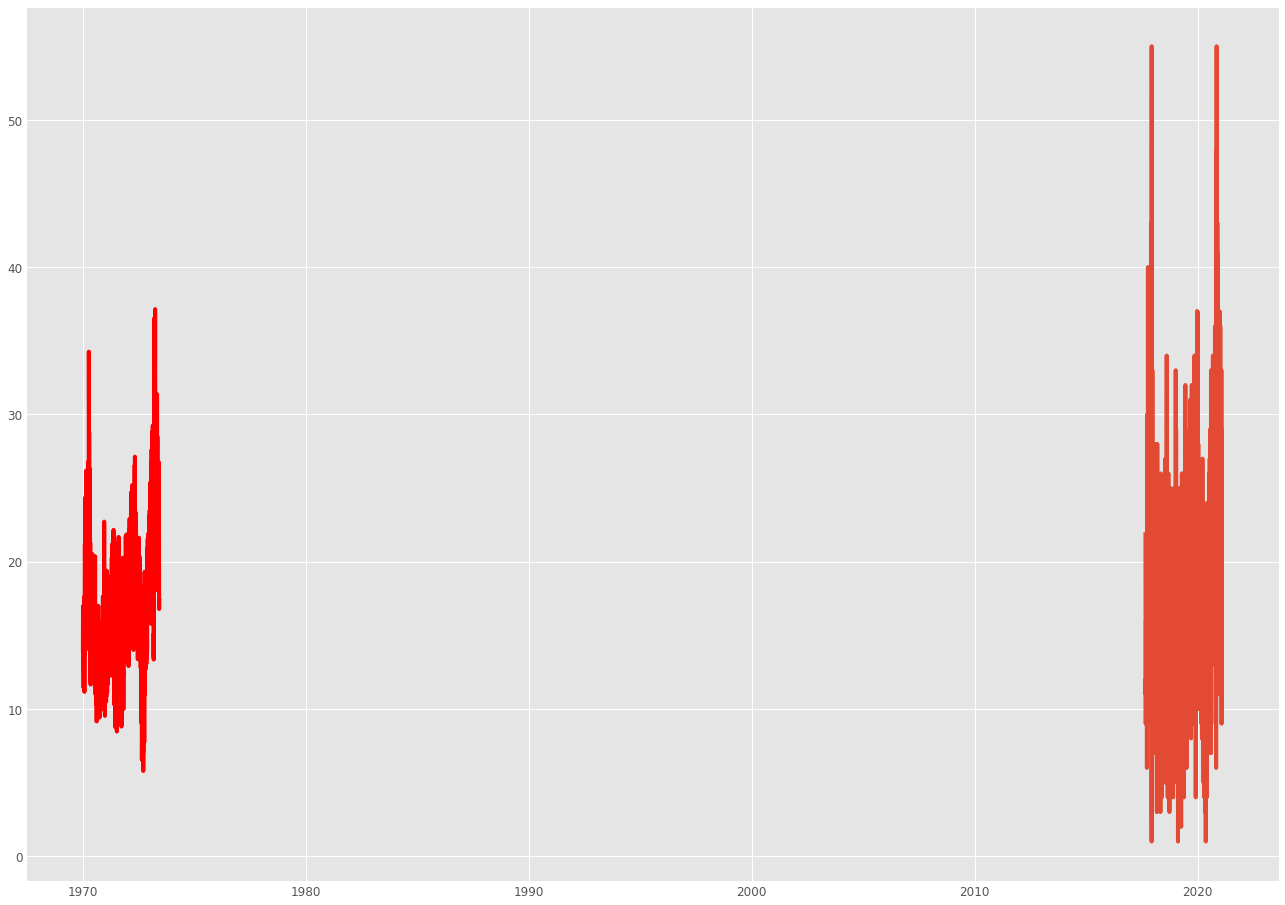

In [68]:
#Arima Train/Test
X = df1.Count
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [69]:
#ARIMA R-squared
r2_score(test, predictions)

0.23190845165598573

In [73]:
mean_absolute_error(test, predictions)

4.72201652484813